In [1]:
# Importing Necessary Modules
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn as nn
from torch import optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Loading the Data
train = r"..\Dataset\train"
test = r"..\Dataset\test"

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

train_folder = ImageFolder(train, transform=train_transform)
test_folder = ImageFolder(test, transform = test_transform)

train_loader = DataLoader(train_folder, batch_size=8, shuffle=True)
test_loader = DataLoader(test_folder, batch_size=8)

# Class Names
class_names = train_folder.classes

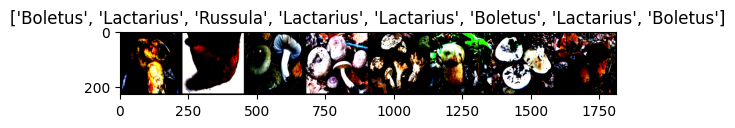

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


# Getting a batch of training data
inputs, classes = next(iter(train_loader))

# Making a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
# Defining the Training Loop
def train(train_loader ,test_loader, model, optimizer, loss_fn, num_epochs = 1):
    for epoch in range(num_epochs):
        train_loss, test_loss = 0, 0
        train_acc, test_acc = 0, 0
        model.train()
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()

            train_loss+=loss.item()
            train_acc += torch.eq(out.argmax(-1), y).sum().item()
        
        model.eval()
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            loss = loss_fn(out, y)
            
            test_loss+=loss.item()
            test_acc += torch.eq(out.argmax(-1), y).sum().item()
        

        train_loss/= len(train_loader.dataset)
        train_acc /=len(train_loader.dataset)

        test_loss/= len(test_loader.dataset)
        test_acc /=len(test_loader.dataset)
        #if (epoch+1)%5==0:
        print(f"Epoch:{epoch+1}")
        print(f"Train Accuracy: {train_acc:.2f}   Train Loss : {train_loss:.2f} ")
        print(f"Test Accuracy:  {test_acc:.2f}   Test Loss: {test_loss:.2f}")

In [5]:
# Loading the MobileNetV3 Model as a Fixed Feature Extractor
model = torchvision.models.mobilenet_v3_small(weights='DEFAULT')
for param in model.parameters():
    param.requires_grad = False

model.classifier[3] = nn.Linear(in_features=1024, out_features=3, bias=True)
model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001)

In [6]:
# Training the Model
train(train_loader, test_loader, model, optimizer, criterion, num_epochs=50)

Epoch:1
Train Accuracy: 0.40   Train Loss : 0.13 
Test Accuracy:  0.56   Test Loss: 0.13
Epoch:2
Train Accuracy: 0.57   Train Loss : 0.12 
Test Accuracy:  0.68   Test Loss: 0.11
Epoch:3
Train Accuracy: 0.66   Train Loss : 0.11 
Test Accuracy:  0.74   Test Loss: 0.11
Epoch:4
Train Accuracy: 0.68   Train Loss : 0.10 
Test Accuracy:  0.76   Test Loss: 0.10
Epoch:5
Train Accuracy: 0.73   Train Loss : 0.10 
Test Accuracy:  0.77   Test Loss: 0.09
Epoch:6
Train Accuracy: 0.71   Train Loss : 0.10 
Test Accuracy:  0.79   Test Loss: 0.09
Epoch:7
Train Accuracy: 0.74   Train Loss : 0.09 
Test Accuracy:  0.80   Test Loss: 0.09
Epoch:8
Train Accuracy: 0.75   Train Loss : 0.09 
Test Accuracy:  0.81   Test Loss: 0.08
Epoch:9
Train Accuracy: 0.76   Train Loss : 0.09 
Test Accuracy:  0.81   Test Loss: 0.08
Epoch:10
Train Accuracy: 0.76   Train Loss : 0.08 
Test Accuracy:  0.82   Test Loss: 0.08
Epoch:11
Train Accuracy: 0.79   Train Loss : 0.08 
Test Accuracy:  0.82   Test Loss: 0.08
Epoch:12
Train Accu

In [7]:
# Saving the Model
torch.save(model, "MobileNet_v3.pt")